# FINAL NPZD PROTOTYPE

# NOTE:

actually assemble all variables involved with a flux, and register from there!
add that extra level of complexity! so the problem if one has a dim and another doesn't

here list of vars supplied and flux routing could happen!!!

do this!

also,
think again how to use groups in the cleanest way possible!




In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [3]:
from phydra.components.variables import SV, SVArray

In [4]:
from phydra.components.fluxes import (LinearForcingInput,
                                      LinearMortality,
                                      MonodGrowth)
from phydra.components.forcings import ConstantForcing, GlobalSlabClimatologyForcing

In [5]:
import numpy as np

np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)

In [6]:
@phydra.comp
class ListInputFlux:
    """ get variable input of multiple labels as list
        and do the routing etc.
    """
    resources = phydra.variable(foreign=True, negative=True, flux='growth', list_input=True, dims='resources')
    consumer = phydra.variable(foreign=True, flux='growth')
    halfsat = phydra.parameter()
    
    @phydra.flux(dims='resources')
    def growth(self, resources, consumer, halfsat):
        # print(resources, consumer, halfsat)
        return resources / (sum(resources) + halfsat) * consumer
    

In [7]:
def funct(resources, consumer):
    print(resources, consumer)
    return resources / (sum(resources) + "2.") * consumer

vec_funct = np.vectorize(funct, signature="(m),()->(m)", excluded='resources')

resources = np.array(["1.", "2."], dtype='object')
consumer = np.array(["0.1"], dtype='object')

vec_funct(resources, consumer)

['1.' '2.'] 0.1


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [8]:
NPZD = phydra.create({'Nutrient':SV,
                      'Nutrient2':SV,
                      'Phytoplankton':SV,

                      'Input':LinearForcingInput, 
                      'Input2':LinearForcingInput, 
                      #'Growth': MonodGrowth,
                      'Mortality': LinearMortality,
                      
                      # HERE NEED TO ADD THIS:
                      'N0':GlobalSlabClimatologyForcing,
                      'N0x':ConstantForcing,
                      
                      'ListInputFlux':ListInputFlux,
                     })

In [9]:
NPZD

<xsimlab.Model (12 processes, 28 inputs)>
Core
    solver_type       [in]
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
Nutrient2
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
Phytoplankton
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
N0
    rbb               [in] constant value of forcing
    lon               [in] constant value of forcing
    k                 [in] The degree of the spline fit
    lat               [in] constant value of forcing
    forcing_label     [in] label / 
    dataset           [in] Options: 'n0x', 'mld', 'tmld', 'par'
    smooth            [in] smoothing conditions, larger values = st...
N0x
    value             [in] constant value of forcing
    forcing

In [10]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,10,0.1),
            input_vars={
                'Nutrient':{'var_label':'N', 'var_init':3.},
                'Nutrient2':{'var_label':'N2', 'var_init':3.},
                'Phytoplankton':{'var_label':'P', 'var_init':0.1},
                
                'Input':{'var':'N', 'rate':0.1, 'forcing':'N0'},
                'Input2':{'var':'N2', 'rate':0.05, 'forcing':'N0'},
                
                #'Growth':{'consumer':'P', 'resource':'N', 'halfsat':1.5},
                
                'Mortality':{'var':'P', 'rate':0.1},
                
                'N0x':{'forcing_label':'N0x', 'value':2.},
                'N0':{'forcing_label':'N0', 'dataset':'n0x',
                      'lat':47, 'lon':-20, 'rbb':2,
                      'smooth':5, 'k':2},
                
                'ListInputFlux':{'resources':['N', 'N2'], 'consumer':'P', 'halfsat':2},
            },
            output_vars="ALL"
            )

In [11]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
VAR IN DICT defaultdict(None, {'time': array([0])})
Initializing component Nutrient
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
Initializing component Nutrient2
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N2'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N2'}]})
Initializing component Phytoplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
Initializing component N0
returning input arg dict defaultdict(<class 'list'>, {'forcs': [{'var': 'forcing', 'label': 'N0'}], 'pars': [{'var': 'dataset', 'label': 'N0_dataset'}, {'var': 'lat', 'label': 'N0_lat'}, {'var': 'lon', 'label': 'N0_lon'}, {'var': 'rbb', 'label': 'N0_rbb'}, {'var': 'smooth

In [12]:
odeint_out

<xarray.Dataset>
Dimensions:                      (clock: 2, input_time: 100, resources: 2, time: 100)
Coordinates:
  * clock                        (clock) float64 0.0 0.1
Dimensions without coordinates: input_time, resources, time
Data variables:
    Core__solver_type            <U6 'odeint'
    Input2__forcing              <U2 'N0'
    Input2__input_value          (time) float64 0.2545 0.2546 ... 0.2739 0.2741
    Input2__rate                 float64 0.05
    Input2__var                  <U2 'N2'
    Input__forcing               <U2 'N0'
    Input__input_value           (time) float64 0.509 0.5092 ... 0.5479 0.5482
    Input__rate                  float64 0.1
    Input__var                   <U1 'N'
    ListInputFlux__consumer      <U1 'P'
    ListInputFlux__growth_value  (resources, time) float64 0.0375 ... 0.2727
    ListInputFlux__halfsat       int64 2
    ListInputFlux__resources     (resources) <U2 'N' 'N2'
    Mortality__death_value       (time) float64 0.01 0.01033 ... 0.9451 0.9438
    Mortality__rate              float64 0.1
    Mortality__var               <U1 'P'
    N0__dataset                  <U3 'n0x'
    N0__forcing_label            <U2 'N0'
    N0__forcing_value            (time) float64 5.09 5.094 5.099 ... 5.481 5.484
    N0__k                        int64 2
    N0__lat                      int64 47
    N0__lon                      int64 -20
    N0__rbb                      int64 2
    N0__smooth                   int64 5
    N0x__forcing_label           <U3 'N0x'
    N0x__forcing_value           (time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    N0x__value                   float64 2.0
    Nutrient2__var_init          float64 3.0
    Nutrient2__var_label         <U2 'N2'
    Nutrient2__var_value         (time) float64 3.0 3.022 ... 0.06321 0.06335
    Nutrient__var_init           float64 3.0
    Nutrient__var_label          <U1 'N'
    Nutrient__var_value          (time) float64 3.0 3.047 ... 0.1264 0.1267
    Phytoplankton__var_init      float64 0.1
    Phytoplankton__var_label     <U1 'P'
    Phytoplankton__var_value     (time) float64 0.1 0.1067 ... 9.445 9.432
    Time__time                   (input_time) float64 0.0 0.1 0.2 ... 9.8 9.9

In [13]:
import matplotlib.pyplot as plt

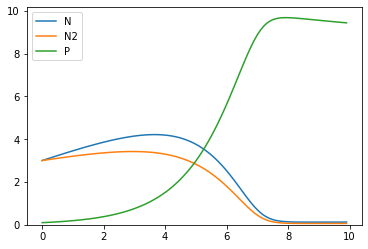

In [14]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Nutrient2__var_value, label='N2')
plt.plot(time, odeint_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

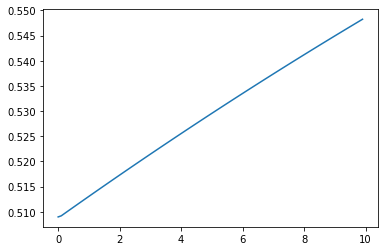

In [15]:
plt.plot(time, odeint_out.Input__input_value, label='N Input')

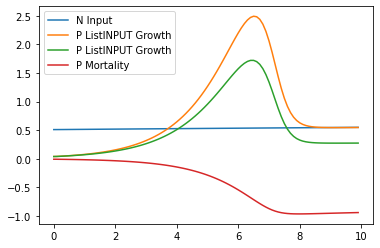

In [16]:
plt.plot(time, odeint_out.Input__input_value, label='N Input')
plt.plot(time, odeint_out.ListInputFlux__growth_value.T, label='P ListINPUT Growth')
plt.plot(time, -odeint_out.Mortality__death_value, label='P Mortality')
plt.legend()

In [17]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

In [18]:
with NPZD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
Initializing component Nutrient2
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N2'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N2'}]})
Initializing component Phytoplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
Initializing component N0
returning input arg dict defaultdict(<class 'list'>, {'forcs': [{'var': 'forcing', 'label': 'N0'}], 'pars': [{'var': 'dataset', 'label': 'N0_dataset'}, {'var': 'lat', 'label': 'N0_lat'}, {'var': 'lon', 'label': 'N0_lon'}, {'var': 'rbb', 'label': 'N0_rbb'}, {'var': 'smooth', 'label': 'N0_smooth'}, {'var': 'k', 'label': 'N0_

In [19]:
stepwise_out

<xarray.Dataset>
Dimensions:                      (clock: 100, input_time: 100, resources: 2, time: 100)
Coordinates:
  * clock                        (clock) float64 0.0 0.1 0.2 0.3 ... 9.7 9.8 9.9
Dimensions without coordinates: input_time, resources, time
Data variables:
    Core__solver_type            <U8 'stepwise'
    Input2__forcing              <U2 'N0'
    Input2__input_value          (time) float64 0.2545 0.2547 ... 0.274 0.2742
    Input2__rate                 float64 0.05
    Input2__var                  <U2 'N2'
    Input__forcing               <U2 'N0'
    Input__input_value           (time) float64 0.509 0.5094 ... 0.5481 0.5484
    Input__rate                  float64 0.1
    Input__var                   <U1 'N'
    ListInputFlux__consumer      <U1 'P'
    ListInputFlux__growth_value  (resources, time) float64 0.0375 ... 0.2727
    ListInputFlux__halfsat       int64 2
    ListInputFlux__resources     (resources) <U2 'N' 'N2'
    Mortality__death_value       (time) float64 0.01 0.01 ... 0.9613 0.9599
    Mortality__rate              float64 0.1
    Mortality__var               <U1 'P'
    N0__dataset                  <U3 'n0x'
    N0__forcing_label            <U2 'N0'
    N0__forcing_value            (time) float64 5.09 5.094 5.099 ... 5.481 5.484
    N0__k                        int64 2
    N0__lat                      int64 47
    N0__lon                      int64 -20
    N0__rbb                      int64 2
    N0__smooth                   int64 5
    N0x__forcing_label           <U3 'N0x'
    N0x__forcing_value           (time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    N0x__value                   float64 2.0
    Nutrient2__var_init          float64 3.0
    Nutrient2__var_label         <U2 'N2'
    Nutrient2__var_value         (time) float64 3.0 3.022 ... 0.06212 0.06227
    Nutrient__var_init           float64 3.0
    Nutrient__var_label          <U1 'N'
    Nutrient__var_value          (time) float64 3.0 3.047 ... 0.1242 0.1245
    Phytoplankton__var_init      float64 0.1
    Phytoplankton__var_label     <U1 'P'
    Phytoplankton__var_value     (time) float64 0.1 0.1065 ... 9.599 9.585
    Time__time                   (input_time) float64 0.0 0.1 0.2 ... 9.8 9.9

In [20]:
import matplotlib.pyplot as plt

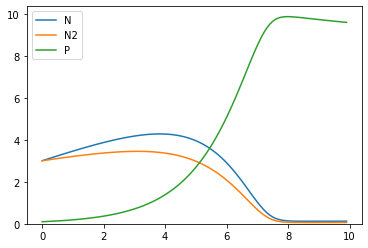

In [21]:
time = stepwise_out.Time__time

plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Nutrient2__var_value, label='N2')
plt.plot(time, stepwise_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

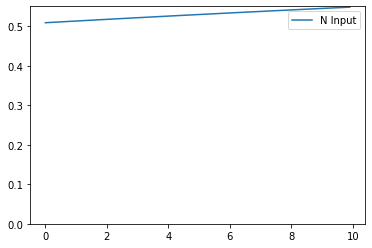

In [22]:
plt.plot(time, stepwise_out.Input__input_value, label='N Input')
plt.ylim(bottom=0)
plt.legend()

In [23]:
gekko_setup = phydra.update_setup(model=NPZD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [24]:
with NPZD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N'}]})
Initializing component Nutrient2
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N2'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'N2'}]})
Initializing component Phytoplankton
returning input arg dict defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
defaultdict(<class 'list'>, {'vars': [{'var': 'var', 'label': 'P'}]})
Initializing component N0
returning input arg dict defaultdict(<class 'list'>, {'forcs': [{'var': 'forcing', 'label': 'N0'}], 'pars': [{'var': 'dataset', 'label': 'N0_dataset'}, {'var': 'lat', 'label': 'N0_lat'}, {'var': 'lon', 'label': 'N0_lon'}, {'var': 'rbb', 'label': 'N0_rbb'}, {'var': 'smooth', 'label': 'N0_smooth'}, {'var': 'k', 'label': 'N0_

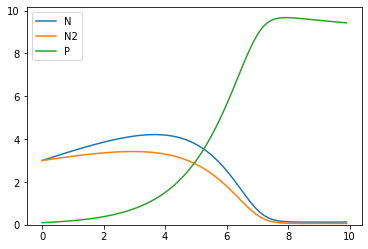

In [26]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Nutrient2__var_value, label='N2')
plt.plot(time, gekko_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

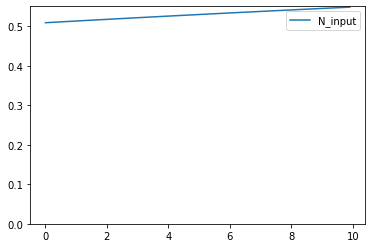

In [27]:
plt.plot(time, gekko_out.Input__input_value, label='N_input')
plt.ylim(bottom=0)
plt.legend()